# Importation des packages nécessaires

Ci dessous, les packages et outils que nous avons utilisés durant le projet :

In [1]:
import pandas as pd
import numpy as np

import pickle
import os

import email.policy
from email.utils import parsedate_to_datetime
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Loading BokehJS ...

# Accès au jeu de données

Avant de créer le Dataframe, importons les données dans le notebook.
Le lecteur est prié de mettre le chemin des données ham et spam qui lui ont été fournies avec ce notebook.

In [2]:
####################### ECRIRE LES CHEMINS MENANT AUX DONNEES ######################
# exemple : spam_path = r'C:\Users\alexis\Desktop\projet\spam' 
#           ham_path = r'C:\Users\alexis\Desktop\projet\ham'

spam_path = r'C:\Users\peyre\Desktop\data\projet spam\spam' 
ham_path = r'C:\Users\peyre\Desktop\data\projet spam\ham'


In [3]:
# Concerne les membres du groupe
# name = 'alexis' #

# if name == 'felix':
#     spam_path = r'C:\Users\peyre\Desktop\data\projet spam\spam'
#     ham_path = r'C:\Users\peyre\Desktop\data\projet spam\ham'
# elif name == 'robin':
#     spam_path = '/home/spawnersky/Documents/Data Science/Projet détection spam/spam'
#     ham_path = '/home/spawnersky/Documents/Data Science/Projet détection spam/ham'
# elif name == 'alexis':
#     spam_path = r'C:\Users\alexis\Desktop\projet\spam'
#     ham_path = r'C:\Users\alexis\Desktop\projet\ham'
# else:
#     print('Tu ne fais pas partie du groupe !')

# Création du dataframe et des features

Les prochaines cellules servent à la création du dataframe, et des features que nous avons décidé d'ajouter.

In [4]:
ham_filenames = [name for name in sorted(os.listdir(ham_path))]
spam_filenames = [name for name in sorted(os.listdir(spam_path))]


def load_email_spam(filename):
    directory = spam_path
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

def load_email_ham(filename):
    directory = ham_path
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)    

    
spam_emails = [load_email_spam(filename=name) for name in spam_filenames]    
ham_emails = [load_email_ham(filename=name) for name in ham_filenames]  

## Suppression des spams qui poseront problème lors de la création du dictionnaire dico_spam (voir plus bas)
del spam_emails[0]
del spam_emails[311]
del spam_emails[312]
del spam_emails[475]

In [5]:
spam_header=[]
for email in spam_emails:
    header = email.keys() 
    spam_header.append(header)

ham_header=[]
for email in ham_emails:
    header = email.keys() 
    ham_header.append(header)  

spam_type=[]
for email in spam_emails:
    message = email.get_content_type()
    spam_type.append(message)
# print(pd.DataFrame(spam_type)[0].value_counts(normalize=True))

ham_type=[]
for email in ham_emails:
    message = email. get_content_type()
    ham_type.append(message)   
# print(pd.DataFrame(ham_type)[0].value_counts(normalize=True))

ham_bit=[]
for email in ham_emails:
     ham_bit.append(email['Content-Transfer-Encoding'])        
# print(pd.DataFrame(ham_bit)[0].value_counts())

spam_bit=[]
for email in spam_emails:
     spam_bit.append(email['Content-Transfer-Encoding'])        
# print(pd.DataFrame(spam_bit)[0].value_counts())

spam_subject=[]
for email in spam_emails:
    spam_subject.append(email['Subject'])

ham_subject=[]
for email in ham_emails:
    ham_subject.append(email['Subject'])
    
    
# présence de piece jointe
# attachment = piece jointe 

spam_att=[]
for e in spam_emails:
    spam_att.append(e.get_content_disposition())
    
ham_att=[]
for e in ham_emails:
    ham_att.append(e.get_content_disposition())

In [6]:
####### obtention du contenu des mails ########

def email_content(email) :
    for sub_email in email.walk() : 
        if sub_email.get_content_type() not in ['text/plain','text/html'] :
            continue
        try:
            Content = sub_email.get_content()
        except : 
            Content = str(sub_email.get_payload())
        if sub_email.get_content_type() == 'text/plain':
            return Content  
        else : 
            Result = BeautifulSoup(Content, 'html.parser')
            return Result.text.replace('\n\n','')

spam_message=[]
for email in spam_emails:
    message = email_content(email)
    spam_message.append(message)

ham_message=[]
for email in ham_emails:
    message = email_content(email)
    ham_message.append(message)
    
spam_len = []
for message in spam_message:
    l = len(message)
    spam_len.append(l)
#pd.DataFrame({'spam_len':spam_len}).describe()


ham_len = []
for message in ham_message:
    l = len(message)
    ham_len.append(l)
#pd.DataFrame({'ham_len':ham_len}).describe()

In [7]:
##############  Listes de mots  ###############


spam_words = []
for message in spam_message:
    if type(message)==str:
        words=re.findall(r'\w+', message)
    else :
        words = 'None'
    spam_words.append(words)
    
ham_words = []
for message in ham_message:
    if type(message)==str:
        words=re.findall(r'\w+', message)
    else :
        words = 'None'
    ham_words.append(words)

spam_words_nb = []
for liste in spam_words:
    liste=str(liste)
    count = len(re.findall(r'\w+', liste))
    spam_words_nb.append(count)
   

ham_words_nb = []
for liste in ham_words:
    liste=str(liste)
    count=0
    count = len(re.findall(r'\w+', liste))
    ham_words_nb.append(count)

In [8]:
####   Nombre de mots en Majuscule dans le mail #####

def upper_words_nb (word_list):
    WORDS_nb = 0
    for word in word_list :
        temp = sum(1 for c in word if c.isupper())
        if (temp == len(word)) & (temp > 1) : #Pour éviter de compter la première personne du singulier : "I"
            WORDS_nb += 1
    return WORDS_nb


spam_nb_upper_words = []
for mail in spam_words :
    spam_nb_upper_words.append(upper_words_nb(mail))

ham_nb_upper_words = []

for mail in ham_words :
    ham_nb_upper_words.append(upper_words_nb(mail))

In [9]:
################### PONCTUATION ET SYMBOLE #############################
liste_ponct = ['€','!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']


def symb_nb (word_list):
    symb_nb = 0
    for word in word_list :
        temp = sum(1 for c in word if c in liste_ponct)
        if temp > 0 : 
            symb_nb += temp
    return symb_nb

spam_symb_nb = []
for mail in spam_message :
    spam_symb_nb.append(symb_nb(mail))

ham_symb_nb = []
for mail in ham_message :
    ham_symb_nb.append(symb_nb(mail))
#pd.DataFrame(ham_symb_nb).describe()

In [10]:
################# Detection des lien URL dans les mails ################


#compilation de l'expression régulière

r=re.compile(r"http?://[a-zA-z0-9./-]+")


def nb_http(text):
    liste=[]
    for val in text:
        count=0
        try: 
            url=r.finditer(val)
        except: continue
        for m in url:
            count+=1
        liste.append(count)
    return liste

nb_http_spam=nb_http(spam_message)
nb_http_ham=nb_http(ham_message)

In [11]:
# liste de tous les types de headers
# hams
keys_liste_de_listes_hams = [] # pour chaque email une liste de headers : [[...],[...],[...]]

for email in ham_emails:
    keys_liste_de_listes_hams.append(email.keys())

keys_liste_de_listes_hams
keys_liste_hams = [] # une liste unique : [...,...,...,...,...,]

for liste in keys_liste_de_listes_hams:
    keys_liste_hams.extend(liste)

# spams    
keys_liste_de_listes_spams = [] # pour chaque email une liste de headers : [[...],[...],[...]]

for email in spam_emails:
    keys_liste_de_listes_spams.append(email.keys())
    
keys_liste_spams = [] # une liste unique : [...,...,...,...,...,]

for liste in keys_liste_de_listes_spams:
    keys_liste_spams.extend(liste)
    
# hams + spams
keys_liste = keys_liste_spams + keys_liste_hams
    
uniques_keys = pd.DataFrame(keys_liste)[0].unique() # on garde que les valeurs uniques

# hams
dico_ham = {}
for name in uniques_keys:
        dico_ham[name] = [email[name] for email in ham_emails]

#spam                                                                                                  
dico_spam = {}
for name in uniques_keys:
        dico_spam[name] = [email[name] for email in spam_emails] 
        

# nombre de mails tous types confondus
length_email=len(spam_emails)+len(ham_emails)
# length_email

In [12]:
# fusion des 2 dataframes, contrainte : l'indiçage doit être en décalé car sinon on a [0,1,...498] puis on recommence à [0,1,..2050]

liste_index=list(range(497,length_email))

df_header_spam = pd.DataFrame(dico_spam,index=range(497))
df_header_ham = pd.DataFrame(dico_ham,index=liste_index)

# ajout des variables explicatives words_,message_len,type,attachment, etc.
## dataframe des spams
df_header_spam['words_body_nb']=spam_words_nb
df_header_spam['message_len']=spam_len
df_header_spam['type']=spam_type
df_header_spam['attachment']=spam_att
df_header_spam['upper_words_body_nb']=spam_nb_upper_words
# df_header_spam['language'] = spam_language
df_header_spam['content']=spam_message
df_header_spam['http_body_nb']=nb_http_spam
df_header_spam['symb_body_nb'] = spam_symb_nb

## dataframe des hams
df_header_ham['words_body_nb']=ham_words_nb
df_header_ham['message_len']=ham_len
df_header_ham['type']=ham_type
df_header_ham['attachment']=ham_att
df_header_ham['upper_words_body_nb']=ham_nb_upper_words
# df_header_ham['language'] = ham_language
df_header_ham['content']=ham_message
df_header_ham['http_body_nb']=nb_http_ham
df_header_ham['symb_body_nb'] = ham_symb_nb


# ajout de la variable cible "target" dans les dataframes spam et ham

df_header_spam['target']=[1 for i in range(df_header_spam.shape[0])]
df_header_ham['target']=[0 for i in range(df_header_ham.shape[0])]


#fusion des dataframes
df_header_global=pd.concat([df_header_spam,df_header_ham])


Nous décidons de ne pas regarder le mois et l'année en tant que features.

- Année : contient des valeurs aberrantes (e.g 2022). De plus nous voulons justement nous servir de ce modèle pour prédire les spam dans le futur, donc garder l'année n'a pas de sens ici.
- Mois : les observations se concentrent sur les mois d'août, septembre et octobre. Nous faisons l'hypothèse que le jeu de données n'est pas très fiable à cet endroit. La variable mois ne devrait donc pas être utilisée comme feature. 

In [13]:
######### Modification du format date ########
#A ne lancer qu'une seule fois !

df_header_global.Date = df_header_global.Date.apply(parsedate_to_datetime)

############### Ajout de nouvelles vairables relative au temps##############
df_header_global['hour'] = df_header_global.Date.apply(lambda x : x.hour)
df_header_global['day'] = df_header_global.Date.apply(lambda x : x.day)
df_header_global['weekday'] = df_header_global.Date.apply(lambda x : x.weekday())

df_header_global['hour_int'] = df_header_global.Date.apply(lambda x : x.hour)
df_header_global['fortnight'] = df_header_global.Date.apply(lambda x : x.day)
df_header_global['weekday_int'] = df_header_global.Date.apply(lambda x : x.weekday())

#Regroupement des valeurs des attributs de Date en intervalless discrets
df_header_global['hour_int'] = pd.cut(x=df_header_global['hour_int'], bins=[0,7,23])
df_header_global['fortnight'] = pd.cut(x=df_header_global['fortnight'], bins=[1,15,31])
df_header_global['weekday_int'] = pd.cut(x=df_header_global['weekday_int'], bins=[0,4,6])

# Encodage des variables catégorielles + supression des variables implicites (si 1ère quinzaine =1 => implicitement on sait que 2ème quinzaine =0)
df_header_global=df_header_global.join(pd.get_dummies(df_header_global.iloc[:,258:], drop_first=True))

# Suppression des colonnes initiales contenant les intervalles
df_header_global.drop('hour_int',1,inplace=True)
df_header_global.drop('fortnight',1,inplace=True)
df_header_global.drop('weekday_int',1,inplace=True)


In [14]:
# Encodage de la variable type
df_header_global=df_header_global.join(pd.get_dummies(df_header_global.type, drop_first=True))
df_header_global.head()

# Suppression de la colonne type initiale
df_header_global.drop('type',1,inplace=True)

In [15]:
######################## ETUDE DE L OBJET DU MAIL ###################################

#nb of words
words_subject_nb=[]
for liste in list(df_header_global.Subject):
    liste=str(liste)
    count = len(re.findall(r'\w+', liste))
    words_subject_nb.append(count)
    
#subject length
subject_len = []
for message in df_header_global.Subject:
    l = len(message)
    subject_len.append(l)

############ Le nombre de mots en MAJ #############
df_temp = pd.DataFrame(df_header_global.Subject.apply(lambda x : x.split()).apply(lambda x : upper_words_nb(x)))
df_temp.columns = ['upper_words_subject_nb']
df_header_global = df_header_global.join(df_temp)

########### Le nombre de symboles ###############
liste_ponct = ['€','!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']

def symb_nb_sub (word_list):
    symb_nb = 0
    for word in word_list :
        temp = sum(1 for c in word if c in liste_ponct)
        if temp > 0 : 
            symb_nb += temp
    return symb_nb

df_temp = pd.DataFrame(df_header_global.Subject.apply(lambda x : x.split()).apply(lambda x : symb_nb_sub(x)))
df_temp.columns = ['symb_subject_nb']
df_header_global = df_header_global.join(df_temp)
df_header_global['words_subject_nb']=words_subject_nb
df_header_global['subject_len']=subject_len


In [16]:
#Mots pour adultes dans l'objet du mail

liste_adults=['sex','sexual','erotic','porn','xxx','adult','sexy']

adults_words_spam_body=[]
for liste in spam_words:
    count=0
    for word in liste:
        if word in liste_adults:
            count+=1
    adults_words_spam_body.append(count)

adults_words_ham_body=[]
for liste in ham_words:
    count=0
    for word in liste:
        if word in liste_adults:
            count+=1
    adults_words_ham_body.append(count)

adults_words_body=adults_words_spam_body+adults_words_ham_body





df_header_global['adults_words_body']=adults_words_body


In [17]:
####### Création des features nb de mots contenant à la fois des lettres et des chiffres dans le body et le subject
## ainsi que deu nombre de mots qui sont dans le dictionnaire anglais (que 64 mails pas en anglais)


## Comptage du nombre de mots qui ne sont pas dans le dictionnaire anglais dans le body et le subject
### BODY
from nltk.corpus import words
word_list_en = set(words.words()) #dictionnaire des mots anglais ~ 236k mots
#len(word_list) prints 236736

not_eng_spam_body=[]
for liste in spam_words:
    count=0
    for word in liste:
        if word not in word_list_en:
            count+=1
    not_eng_spam_body.append(count)

not_eng_ham_body=[]
for liste in ham_words:
    count=0
    for word in liste:
        if word not in word_list_en:
            count+=1
    not_eng_ham_body.append(count)

not_eng_body=not_eng_spam_body+not_eng_ham_body

### Message
not_eng_subject=[]
for liste in df_header_global.Subject:
    count=0
    for word in liste:
        if word not in word_list_en:
            count+=1
    not_eng_subject.append(count)

### Liste des regex permetant d'extraire les infos souhaitées
r_word_A=re.compile(r'[0-9!?$€&%-></#]{1,}[a-zA-Z]{1,}[0-9!?$€&%-></#]*')
r_word_B=re.compile(r'[0-9!?$€&%-></#]*[a-zA-Z]{1,}[0-9!?$€&%-></#]{1,}')                     

#liste caractères spéciaux: !?$€&%-></#

#Nb de mots
nb_words_spam=[]
for liste in spam_words:
    count=0
    for word in liste:
        count+=1
    nb_words_spam.append(count)


nb_words_ham=[]
for liste in ham_words:
    count=0
    for word in liste:
        count+=1
    nb_words_ham.append(count)
nb_words=nb_words_spam + nb_words_ham
        
#fusion des listes ham et spam

#création des colonnes dans le dataframe
df_header_global['not_eng_body']=not_eng_body
df_header_global['not_eng_subject']=not_eng_subject



In [18]:
#----------------------------- Présence de chiffre dans l'adresse mail expéditeur ---------------------------------
#       Variable binaire

adresse_chiffre = []
for adresse in df_header_global['From']:
        if '0' in adresse:
            n = 1
        elif '1' in adresse:
            n=1
        elif '2' in adresse:
            n=1
        elif '3' in adresse:
            n=1
        elif '4' in adresse:
            n=1
        elif '5' in adresse:
            n=1
        elif '6' in adresse:
            n=1
        elif '7' in adresse:
            n=1
        elif '8' in adresse:
            n=1
        elif '9' in adresse:
            n=1
        else:
            n=0
        adresse_chiffre.append(n)
        
df_header_global['nb_in_adress_exp']=adresse_chiffre

In [19]:
# Nombre d'espace et ratio espace/message_len
space_body_nb = []
for message in df_header_global.content:
    count = 0
    if type(message) == str:
        space = sum(1 for space in message if space in ' ')
        if space > 0 :
            count += space
    space_body_nb.append(count)
    
df_header_global['space_body_nb'] = space_body_nb
df_header_global['space_body_ratio'] = df_header_global['space_body_nb']/df_header_global['message_len']

In [20]:
# Supression des colonnes en double

colonne = df_header_global.columns

liste_h = []
colonne_liste =[]
for col in colonne:
    if col.lower() not in liste_h:
        liste_h.append(col.lower())
        colonne_liste.append(col)
    
delete_liste = []

for col in colonne:
    if col not in colonne_liste:
        delete_liste.append(col)

df_header_global.drop( delete_liste , axis=1, inplace =True)

Une fois toutes ces étapes effectuées, nous obtenons un dataframe de taille : 3048 observations et 263 variables (dont la variable target : 1 = spam, 0 = ham)

In [21]:
df_header_global

,Return-Path,Delivered-To,Received,From,To,Subject,Date,MIME-Version,Message-ID,Content-Type,...,upper_words_subject_nb,symb_subject_nb,words_subject_nb,subject_len,adults_words_body,not_eng_body,not_eng_subject,nb_in_adress_exp,space_body_nb,space_body_ratio
0,<12a1mailbot1@web.de>,zzzz@localhost.example.com,from localhost (localhost [127.0.0.1])\tby pho...,12a1mailbot1@web.de,dcek1a1@netsgo.com,Life Insurance - Why Pay More?,2002-08-21 20:31:57-16:00,1.0,<0103c1042001882DD_IT7@dd_it7>,"text/html; charset=""iso-8859-1""",...,0,2,5,30,0,74,7,1,288,0.259226
1,<ilug-admin@linux.ie>,zzzz@localhost.example.com,from localhost (localhost [127.0.0.1])\tby pho...,Slim Down <taylor@s3.serveimage.com>,ilug@linux.ie,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,2002-08-22 06:18:18-06:00,1.0,<59e6301c249d5$ffb7ea20$1606fea9@freeyankeedom...,"text/plain; charset=""iso-8859-1""",...,0,4,12,53,0,97,24,1,64,0.081946
2,<sabrina@mx3.1premio.com>,zzzz@localhost.example.com,from localhost (localhost [127.0.0.1])\tby pho...,Slim Down <sabrina@mx3.1premio.com>,zzzz@example.com,Guaranteed to lose 10-12 lbs in 30 days ...,2002-08-22 07:36:19-06:00,1.0,<9a63c01c249e0$e5a9d610$1106fea9@freeyankeedom...,"text/plain; charset=""iso-8859-1""",...,0,2,11,71,0,85,46,1,54,0.086400
3,<wsup@playful.com>,zzzz@localhost.example.com,from localhost (localhost [127.0.0.1])\tby pho...,Account Services <wsup@playful.com>,zzzz@example.com,Re: Fw: User Name & Password to Membership To ...,2002-08-22 08:13:35-07:00,1.0,<20020822151301.694632EE5A@smtp.easydns.com>,"text/plain; charset=""iso-8859-1""",...,0,5,14,76,5,207,18,0,518,0.178375
4,<social-admin@linux.ie>,zzzz@localhost.example.com,from localhost (localhost [127.0.0.1])\tby pho...,Slim n Trim <yenene@mx2.1premio.com>,social@linux.ie,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,2002-08-22 09:33:07-06:00,1.0,<104c1101c249f1$36e098b0$0b06fea9@freeyankeedo...,"text/plain; charset=""iso-8859-1""",...,0,6,14,64,0,69,27,1,58,0.088012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,<rssfeeds@example.com>,yyyy@localhost.example.com,from localhost (jalapeno [127.0.0.1])\tby jmas...,newscientist <rssfeeds@example.com>,yyyy@example.com,Gene technique reveals human evolution,2002-10-10 08:04:25,None,<200210100804.g9A84PK14188@dogma.slashnull.org>,"text/plain; encoding=""utf-8""",...,0,0,5,38,0,17,4,0,22,0.111675
3044,<rssfeeds@example.com>,yyyy@localhost.example.com,from localhost (jalapeno [127.0.0.1])\tby jmas...,guardian <rssfeeds@example.com>,yyyy@example.com,Go-ahead for new-style hospitals,2002-10-10 08:04:10,None,<200210100804.g9A84AK14152@dogma.slashnull.org>,"text/plain; encoding=""utf-8""",...,0,2,6,32,0,20,5,0,11,0.067901
3045,<rssfeeds@example.com>,yyyy@localhost.example.com,from localhost (jalapeno [127.0.0.1])\tby jmas...,newscientist <rssfeeds@example.com>,yyyy@example.com,Malicious code hidden in email software,2002-10-10 08:04:26,None,<200210100804.g9A84QK14191@dogma.slashnull.org>,"text/plain; encoding=""utf-8""",...,0,0,6,39,0,15,5,0,18,0.103448
3046,<rssfeeds@example.com>,yyyy@localhost.example.com,from localhost (jalapeno [127.0.0.1])\tby jmas...,guardian <rssfeeds@example.com>,yyyy@example.com,'Flexible' retirement gains ground,2002-10-10 08:04:10,None,<200210100804.g9A84AK14155@dogma.slashnull.org>,"text/plain; encoding=""utf-8""",...,0,0,4,34,0,20,5,0,12,0.077419


# Traitement des valeurs vides

In [22]:
# # remplacement des valeurs manquantes par 0 et des valeurs présentes par 1

liste_bin=['Return-Path', 'Delivered-To', 'Received', 'To',
       'MIME-Version', 'Message-ID', 'Content-Type',
       'Content-Transfer-Encoding', 'X-Authentication-Warning', 'X-Mailer',
       'Thread-Index', 'Content-Class', 'X-Mimeole', 'X-Originalarrivaltime',
       'Sender', 'Errors-To', 'X-Mailman-Version', 'Precedence', 'List-Id',
       'X-Beenthere', 'Cc', 'X-Priority', 'X-MIME-Autoconverted', 'Reply-To',
       'X-MSMail-Priority', 'Importance', 'X-Info', 'X-Info2',
       'X-Precedence-Ref', 'X-MIMETrack', 'X-envelope-info', 'Errors',
       'Content-Disposition', 'X-Topica-Id', 'X-MailScanner',
       'X-Complaints-To', 'Response-id', 'X-Remove-Address', 'X-Responder-ID',
       'X-Library', 'X-Sender', 'Sensitivity', 'Lines', 'List-Unsubscribe',
       'List-Post', 'List-Help', 'List-Subscribe','List-Archive', 'X-Originating-Ip', 'X-Original-Date', 'X-Header',
       'X-Loop-Prevention', 'X-Antiabuse', '1', 'X-Author', 'X-Ema-Cid',
       'X-Ema-Lid', 'X-Ema-PC', 'X-Reply-To', 'Thread-Topic', 'Priority',
       'X-Received', 'Resent-Date', 'Resent-From', 'Resent-To',
       'Resent-Subject', 'Resent-Message-Id', 'X-Antivirus',
       'X-Reynoldspurgedate', 'X-Virus-Scanned', 'Return-Receipt-To',
       'Disposition-Notification-To', 'X-Pmflags', 'X-Uidl', 'Comments',
       'X-Mdaemon-Deliver-To', 'X-Return-Path', 'Delivery-Date',
       'Organization', 'Status', 'X-Status', 'X-Keywords', 'X-UID', 'X-Loop',
       'X-Server', 'X-Organization', 'X-Airmail-Delivered',
       'X-Airmail-Spooled', 'X-Evolution-Source', 'X-M5MailerProjectID',
       'Organisation', 'X-Owner', 'X-RMD-Text', 'X-Accept-Language',
       'Id-Frugaljoe', 'X-Mailid', 'Complain-To','Id-Offerclubmail', 'X-Originating-Server', 'Iplanet-SMTP-Warning',
       'X-Comment', 'In-Reply-To', 'References', 'X-Egroups-Return',
       'X-Apparently-To', 'X-Egroups-From', 'X-Yahoo-Profile', 'Mailing-List',
       'X-Face', 'X-Os', 'User-Agent', 'Content-Description', 'X-Url',
       'X-Image-Url', 'X-Delivery-Agent', 'X-Trusted', 'X-From-Laptop',
       'Mail-Followup-To', 'X-Gnupg-Publickey', 'X-MS-Has-Attach',
       'X-MS-Tnef-Correlator', 'X-User-Info', 'X-X-Sender', 'X-Trace',
       'Reply-BY', 'X-Operating-System', 'X-Message-Flag', 'X-Home-Page',
       'X-Enigmail-Version', 'X-Enigmail-Supports', 'X-Subliminal-Message',
       'Comment', 'X-Privacy', 'X-Bulkmail', 'List-Software', 'List-Digest',
       'X-No-Archive', 'Replied', 'X-Assembled-BY', 'Old-Return-Path',
       'X-Mailing-List', 'Resent-Sender', 'X-Pyzor', 'X-Spam-Status',
       'X-Spam-Level', 'X-NCC-Regid', 'X-GPG-Fingerprint','Cr2_Outbound_MailScanner', 'X-Hotpop', 'X-Mas', 'X-Bugzilla-Reason',
       'X-Server-Uuid', 'X-WSS-Id', 'Forwarded', 'X-Imn', 'X-Nsa',
       'X-Dumb-Filters', 'X-GPG-Key-Fingerprint', 'X-Habeas-Swe-1',
       'X-Habeas-Swe-2', 'X-Habeas-Swe-3', 'X-Habeas-Swe-4', 'X-Habeas-Swe-5',
       'X-Habeas-Swe-6', 'X-Habeas-Swe-7', 'X-Habeas-Swe-8', 'X-Habeas-Swe-9',
       'X-Cell', 'X-Web', 'X-Ucsc-Cats-Mailscanner', 'X-PGP-Dsskey',
       'X-PGP-Rsakey', 'X-Nil', 'X-Blank-Header-Line', 'X-Epoch', 'X-Sasl-Enc',
       'X-Envelope-To', 'X-Attribution', 'X-Uri', 'X-Pair-Authenticated',
       'X-Note', 'X-Sent', 'X-Face-Viewer', 'Old-X-Loop', 'Dcc', 'X-GPG',
       'X-GPG-Keyid', 'X-Tmda-Fingerprint', '>Received', 'X-RCPT-To',
       'X-Newsgroups', 'X-No-Matter-Where-You-Go', 'X-Lookup-Warning',
       'X-Mdremoteip', 'X-Authentication-Info', 'X-GPG-Keyserver',
       'X-GPG-Keynumber','X-Razor-Id', 'X-Scanned-BY', 'Mail-Copies-To', 'X-Spam-Checker',
       'X-Foo', 'X-Injected-Via-Gmane', 'Path', 'NNTP-Posting-Host',
       'NNTP-Posting-Date', 'X-Newsreader', 'X-PGP-Key-1', 'X-PGP-Key_2',
       'X-Copyright(C)', 'X-All-Rights', 'X-Dissemination', 'X-Classification',
       'X-Identifier', 'X-Spam-Filter', 'X-Originatingip',
       'X-Mailscanner-Spamcheck', 'X-Emacs', 'X-Auth-User', 'X-Uvscan-Result',
       'X-Copyright', 'X-Spamadvice', 'X-Vipmail-Smtpmailfrom',
       'X-Vopfilter-Ip', 'X-Authenticated-Sender', 'X-MY-PGP-Fingerprint',
       'X-Disclaimer', 'X-Section', 'X-Quote', 'X-Meow', 'attachment','Date']

df_header_global[liste_bin] = df_header_global[liste_bin].isnull()
df_header_global[liste_bin] = df_header_global[liste_bin].astype(int)
df_header_global[liste_bin] = df_header_global[liste_bin].replace({1:0,0:1})


df_header_global.dropna(inplace=True)

df_header_global.reset_index(drop=True,inplace=True)

df = df_header_global
del df_header_global

df

,Return-Path,Delivered-To,Received,From,To,Subject,Date,MIME-Version,Message-ID,Content-Type,...,upper_words_subject_nb,symb_subject_nb,words_subject_nb,subject_len,adults_words_body,not_eng_body,not_eng_subject,nb_in_adress_exp,space_body_nb,space_body_ratio
0,1,1,1,12a1mailbot1@web.de,1,Life Insurance - Why Pay More?,1,1,1,1,...,0,2,5,30,0,74,7,1,288,0.259226
1,1,1,1,Slim Down <taylor@s3.serveimage.com>,1,[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,1,1,1,1,...,0,4,12,53,0,97,24,1,64,0.081946
2,1,1,1,Slim Down <sabrina@mx3.1premio.com>,1,Guaranteed to lose 10-12 lbs in 30 days ...,1,1,1,1,...,0,2,11,71,0,85,46,1,54,0.086400
3,1,1,1,Account Services <wsup@playful.com>,1,Re: Fw: User Name & Password to Membership To ...,1,1,1,1,...,0,5,14,76,5,207,18,0,518,0.178375
4,1,1,1,Slim n Trim <yenene@mx2.1premio.com>,1,[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,1,1,1,1,...,0,6,14,64,0,69,27,1,58,0.088012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1,1,1,newscientist <rssfeeds@example.com>,1,Gene technique reveals human evolution,1,0,1,1,...,0,0,5,38,0,17,4,0,22,0.111675
3043,1,1,1,guardian <rssfeeds@example.com>,1,Go-ahead for new-style hospitals,1,0,1,1,...,0,2,6,32,0,20,5,0,11,0.067901
3044,1,1,1,newscientist <rssfeeds@example.com>,1,Malicious code hidden in email software,1,0,1,1,...,0,0,6,39,0,15,5,0,18,0.103448
3045,1,1,1,guardian <rssfeeds@example.com>,1,'Flexible' retirement gains ground,1,0,1,1,...,0,0,4,34,0,20,5,0,12,0.077419


# DataViz'

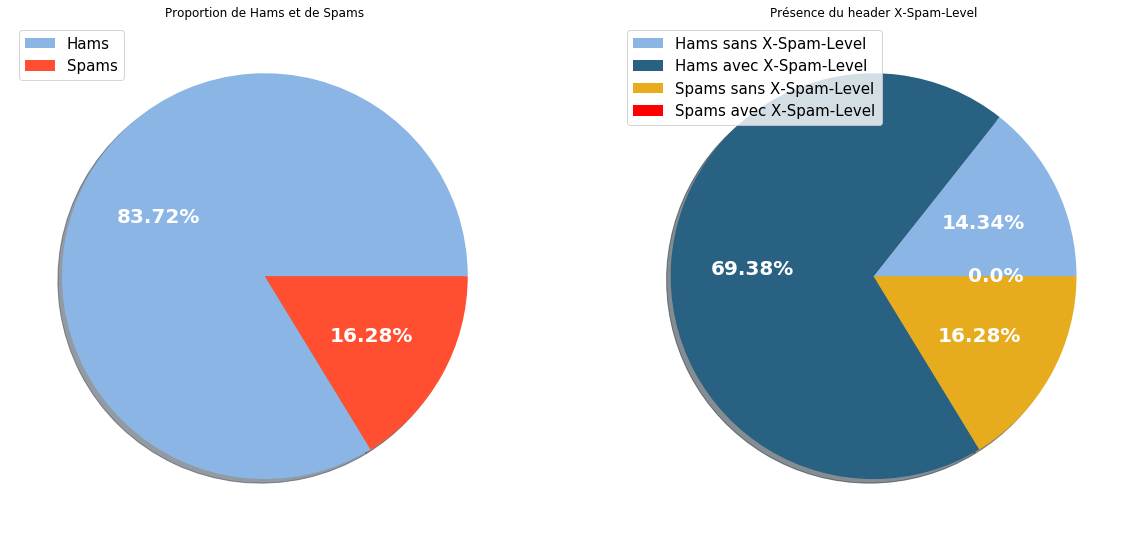

In [23]:
############# Ratio ham / spam ######################

dfX = pd.crosstab(df.target,df['X-Spam-Level'], normalize=True)
plt.figure(figsize =(20,20))

plt.subplot(1,2,1)
plt.pie(df.target.value_counts(),
       shadow = True, 
       autopct = lambda x: str(round(x,2))+"%", pctdistance = 0.6, 
       labels = ['Hams','Spams'],
       colors = ['#8ab5e5','#ff4f30'],
       textprops = {'color':'w','size':20,'weight':'bold'})
plt.legend(loc = 2,fontsize = 15)
plt.title('Proportion de Hams et de Spams')
plt.subplot(1,2,2)
plt.pie(np.array(dfX).flat,
       shadow = True, 
       autopct = lambda x: str(round(x,2))+"%", pctdistance = 0.6, 
       
       colors = ['#8ab5e5','#296183','#e7ac1e','#ff0000'],
       textprops = {'color':'w','fontsize':20,'weight':'bold'})
plt.title("Présence du header X-Spam-Level")
plt.legend(loc = 2,fontsize = 15,labels = ['Hams sans X-Spam-Level','Hams avec X-Spam-Level','Spams sans X-Spam-Level','Spams avec X-Spam-Level']);



In [24]:
############# nombre de valeurs manquantes ###########

non_bin = ['From','Subject','Date','upper_words_subject_nb','symb_subject_nb', 'words_subject_nb',
           'not_eng_body','not_eng_subject','nb_in_adress_exp', 'words_body_nb', 'symb_body_nb',
           'message_len','multipart/related','multipart/mixed','multipart/report','multipart/signed',
           'text/html','text/plain','upper_words_body_nb','content','http_body_nb','Message-ID',
           'subject_len','adults_words_body','target','space_body_nb', 'attachment', 'hour_int_(7, 23]',
           'space_body_ratio','hour','day','weekday','fortnight_(15, 31]','weekday_int_(4, 6]']

df_bin = df.drop(columns = non_bin)

res = pd.DataFrame(index = [0,1])
for var in df_bin:
    res = res.join(df_bin[var].value_counts(normalize=True))

res.drop(index= 1,inplace=True)
res = pd.DataFrame(np.array(res).reshape(df_bin.shape[1],1),index=res.columns,columns=["Null_ratio"])

p = figure(title="Histogramme du ratio de valeurs manquantes dans les variables du header",plot_width = 600, plot_height = 400,
           x_range = (0,1),x_axis_label= "Pourcentage de valeurs manquante", y_axis_label="Nombre de variables")

hist, edges = np.histogram(res, bins = 10)
hist_df = pd.DataFrame({"Null_ratio": hist,
                        "left": edges[:-1],
                        "right": edges[1:]})
hist_df["interval"] = ["%s to %s" %(round(left,2),round(right,2)) for left, right in zip(hist_df["left"], hist_df["right"])]

source = ColumnDataSource(hist_df)
p.quad(bottom = 0, top = "Null_ratio",left = "left", right = "right", source = source, fill_color = 'blue', 
    line_color = "black", fill_alpha = 0.7, hover_fill_alpha = 1.0)

hover = HoverTool(tooltips = [('Interval', '@interval'),('Count', str("@" + "Null_ratio"))])
p.add_tools(hover)

show(p)

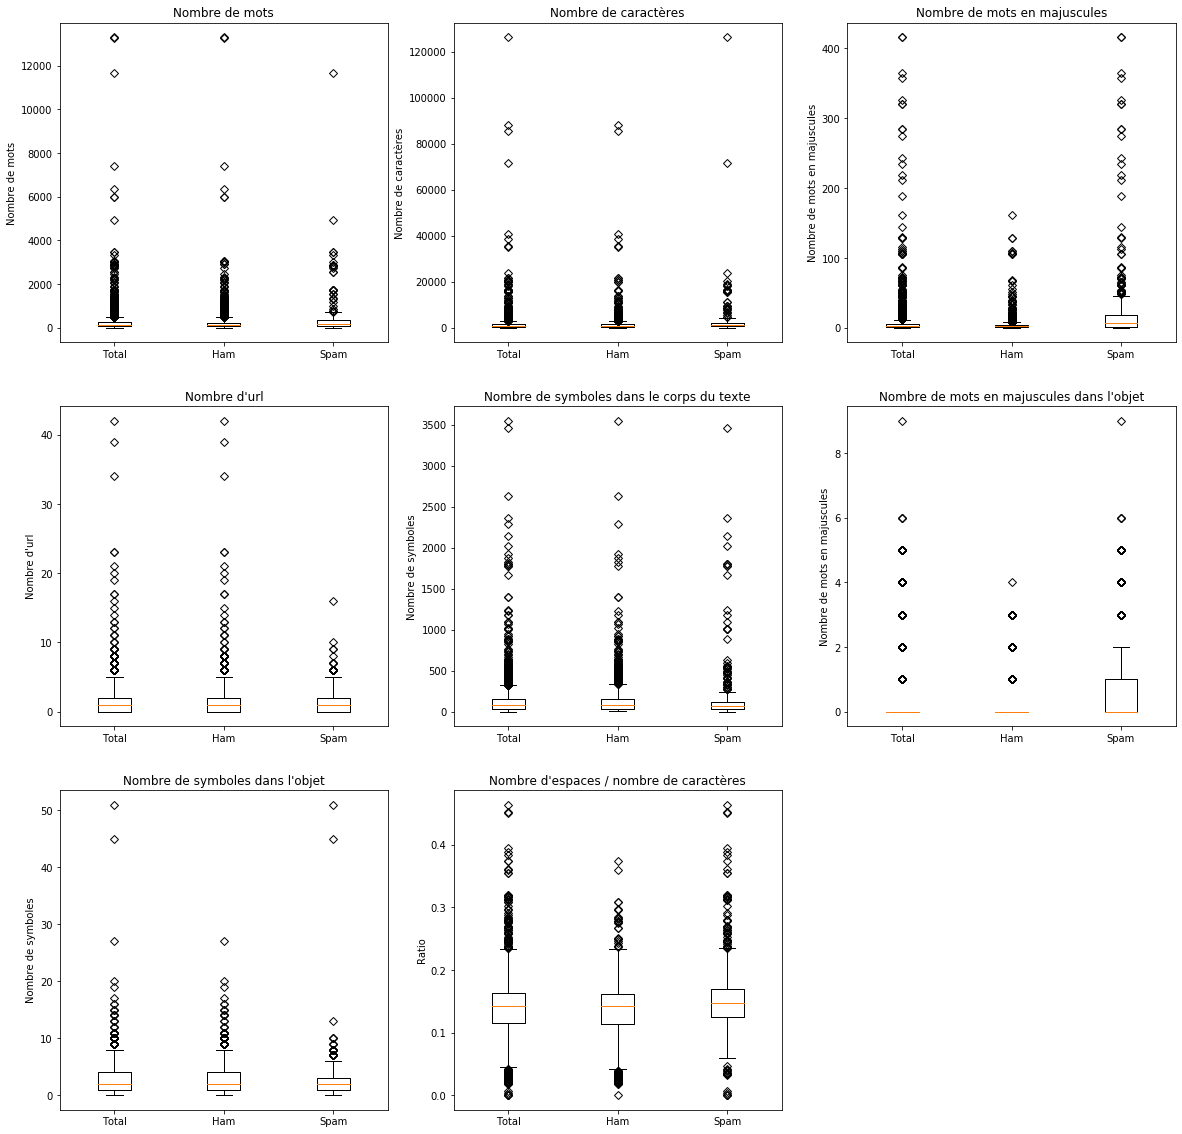

In [25]:
######### Box plot / aberrantes ##################


df_nb = df[['words_body_nb', 'message_len','upper_words_body_nb', 'target',
                 'http_body_nb', 'symb_body_nb', 'upper_words_subject_nb', 'symb_subject_nb','space_body_ratio']]
df_nb = df_nb.fillna(df_nb.mean())
df_nb_spam = df_nb[df_nb['target'] == 1]
df_nb_ham = df_nb[df_nb['target'] == 0]


plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
plt.boxplot((df_nb.words_body_nb,df_nb_ham.words_body_nb,df_nb_spam.words_body_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel('Nombre de mots')
plt.title('Nombre de mots')
plt.subplot(3,3,2)
plt.boxplot((df_nb.message_len,df_nb_ham.message_len,df_nb_spam.message_len),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel('Nombre de caractères')
plt.title('Nombre de caractères')
plt.subplot(3,3,3)
plt.boxplot((df_nb.upper_words_body_nb,df_nb_ham.upper_words_body_nb,df_nb_spam.upper_words_body_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel('Nombre de mots en majuscules')
plt.title('Nombre de mots en majuscules')
plt.subplot(3,3,4)
plt.boxplot((df_nb.http_body_nb,df_nb_ham.http_body_nb,df_nb_spam.http_body_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel("Nombre d'url")
plt.title("Nombre d'url")
plt.subplot(3,3,5)
plt.boxplot((df_nb.symb_body_nb,df_nb_ham.symb_body_nb,df_nb_spam.symb_body_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel("Nombre de symboles")
plt.title("Nombre de symboles dans le corps du texte")
plt.subplot(3,3,6)
plt.boxplot((df_nb.upper_words_subject_nb,df_nb_ham.upper_words_subject_nb,df_nb_spam.upper_words_subject_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel("Nombre de mots en majuscules")
plt.title("Nombre de mots en majuscules dans l'objet")
plt.subplot(3,3,7)
plt.boxplot((df_nb.symb_subject_nb,df_nb_ham.symb_subject_nb,df_nb_spam.symb_subject_nb),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel("Nombre de symboles")
plt.title("Nombre de symboles dans l'objet");
plt.subplot(3,3,8)
plt.boxplot((df_nb.space_body_ratio,df_nb_ham.space_body_ratio,df_nb_spam.space_body_ratio),0,'D',labels = ('Total','Ham','Spam'));
plt.ylabel("Ratio")
plt.title("Nombre d'espaces / nombre de caractères");


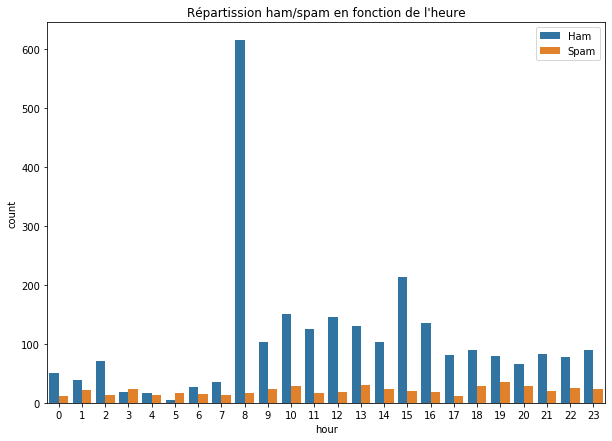

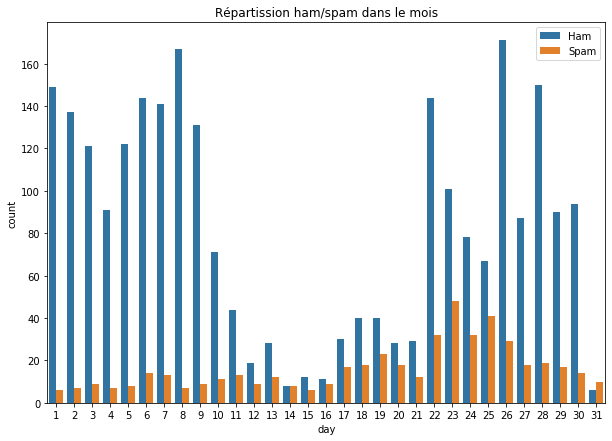

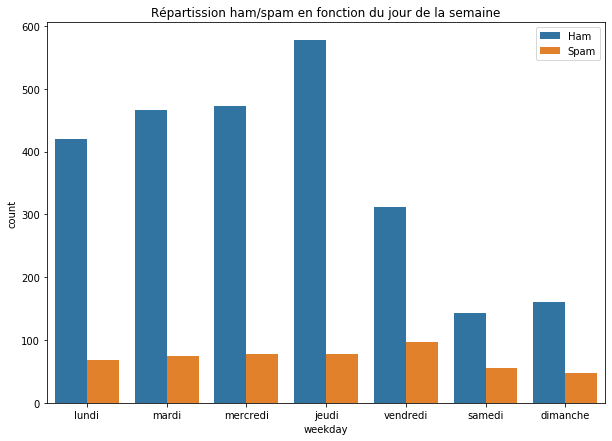

In [26]:
############ ham / spam en fonction du temps ################

new_labels = ['Ham', 'Spam']

fig1, ax1 = plt.subplots(figsize= (10,7))
g1 = sns.countplot(df.hour,hue = df.target, ax = ax1)
g1.set_title("Répartission ham/spam en fonction de l'heure")
for t, l in zip(g1.legend().texts, new_labels): t.set_text(l)
plt.show();


fig2, ax2 = plt.subplots(figsize= (10,7))
g2 = sns.countplot(df.day,hue = df.target, ax = ax2)
g2.set_title("Répartission ham/spam dans le mois")
for t, l in zip(g2.legend().texts, new_labels): t.set_text(l)
plt.show();


fig3, ax3 = plt.subplots(figsize= (10,7))
g3 = sns.countplot(df.weekday,hue = df.target, ax = ax3)
g3.set_title("Répartission ham/spam en fonction du jour de la semaine")
plt.xticks(np.arange(7),['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche'])
for t, l in zip(g3.legend().texts, new_labels): t.set_text(l)
plt.show();

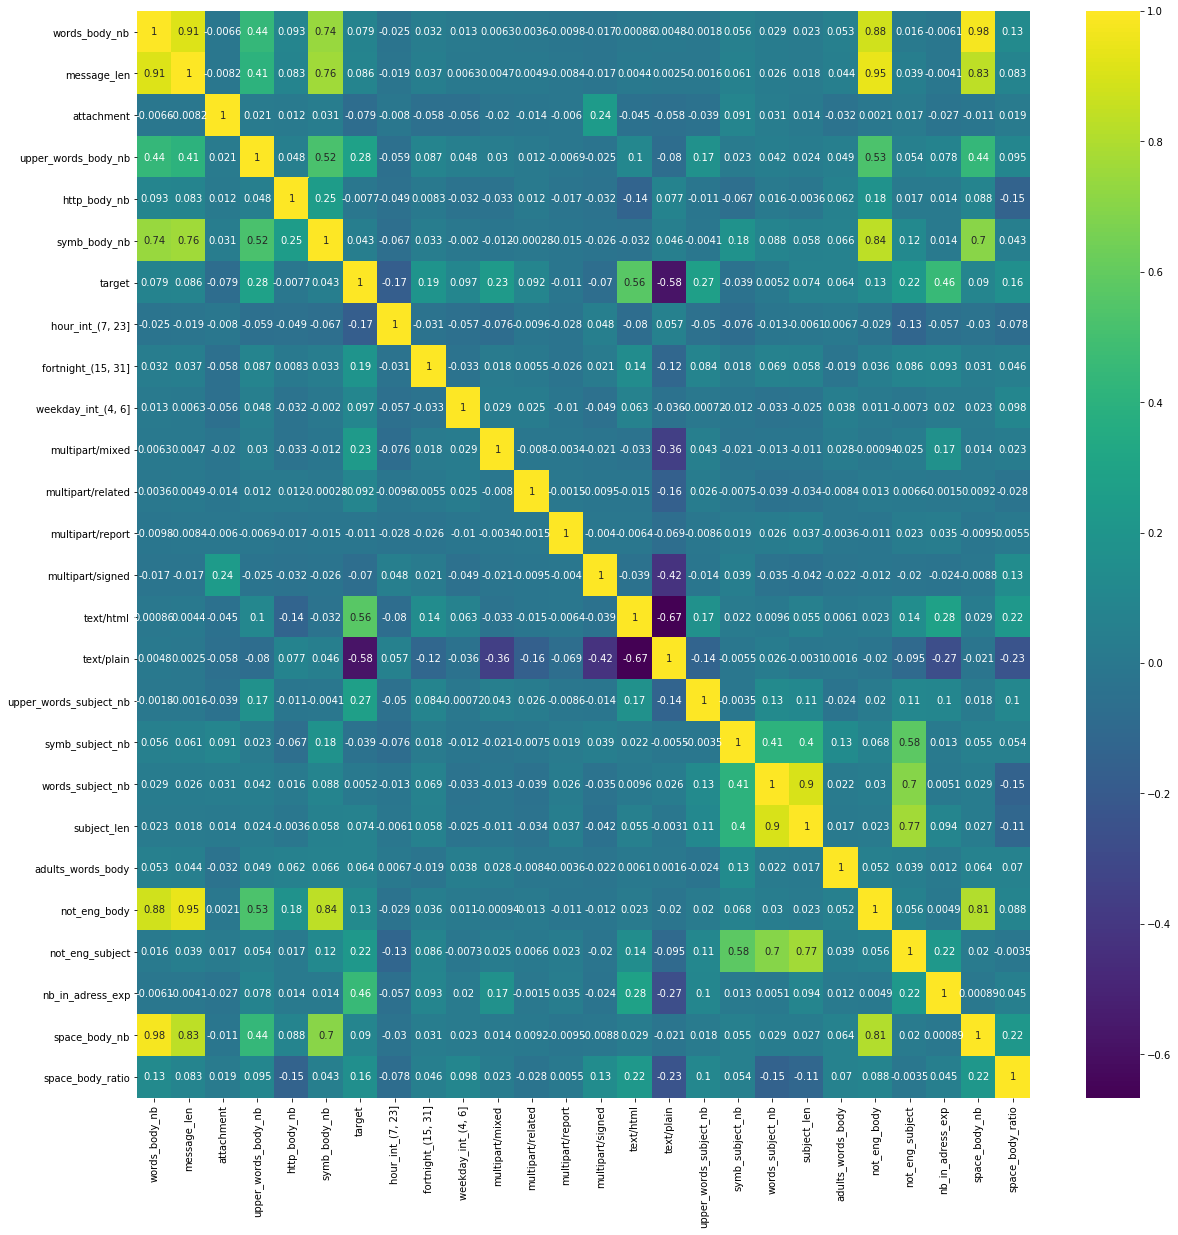

In [27]:
############# Heatmap matrice de correlation ##############

## Sans les variables temporelles non encodées
df_temp = df.drop(columns=['hour','weekday','day'])


liste_var=list(df_temp.iloc[:,233:])
#Nous avons fait ici le choix de n'étudier les corrélations des variables que nous avons créées uniquement.
#En effet, les variables qui correspondent aux items du header contienent une écrasante majorité de valeurs nulles
# Même après les avoir binarisés, nous estimons qu'il n'y a pas vraiment de sens à étudier leur corrélations avec la variable cible ainsi qu'avec les autres variables

corr=df_temp[liste_var].corr()

fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True,cmap="viridis") ;


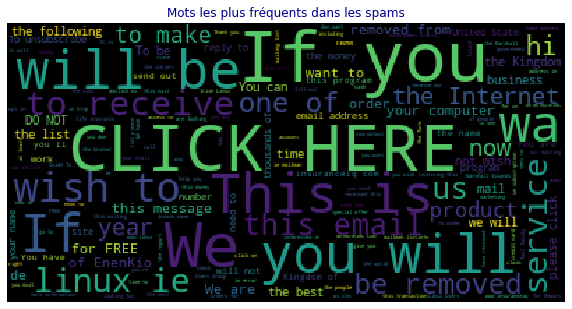

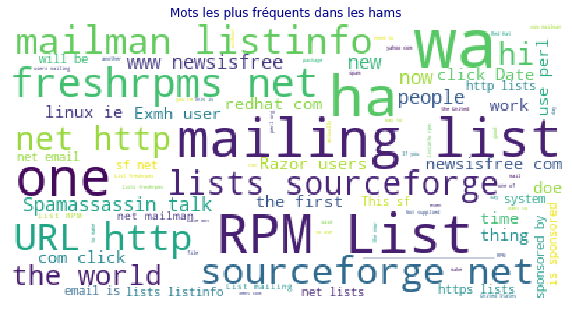

In [28]:
########## WordCloud : quels mots apparaissent le plus dans les spams et dans les hams ?###########


## Liste des mots à enlever 
stop_words = set(STOPWORDS)
#mots_vides=["http","www","the","be,""to","of","us","this","wa","ha","to","linux"]
#stop_words.update(mots_vides)

## Création du texte comptabilisant tous les mots dans les spams
text_spam = ""
for liste in spam_words:
    for word in liste: 
        text_spam +=" " +word

## Création du texte comptabilisant tous les mots dans les hams
text_ham = ""
for liste in ham_words:
    for word in liste: 
        text_ham +=" " +word


def plot_word_cloud(title,text, background_color = "black"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))

    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=200, stopwords=stop_words, mask = None, max_font_size=50, random_state=42)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (10,10))
    wc.generate(text)
    plt.title(title,fontsize=12,color="darkblue")
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

plot_word_cloud('Mots les plus fréquents dans les spams',text_spam,)
plot_word_cloud('Mots les plus fréquents dans les hams',text_ham,background_color = "white")

# Machine learning

# 0) Séparation du jeu de données 

In [29]:
data=df.drop('target',axis=1)
target=df.target

X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2)

# 1) Variante A : analyse sur le header + variables créées

In [30]:
pd.set_option('mode.chained_assignment', None)
# Random State
rdm = np.random.randint(1000000)
#rdm = 12        # 12 pour 100% bonnes réponses
#----------------------------------------------------------------------------------------------------------------------

X_train_num = X_train.select_dtypes(['int64','float64','uint8'])
X_test_num = X_test.select_dtypes(['int64','float64','uint8'])
X_train_nlp = X_train.content
X_test_nlp = X_test.content
vectorizer = CountVectorizer()
X_train_nlp = vectorizer.fit_transform(X_train_nlp).todense()
X_test_nlp = vectorizer.transform(X_test_nlp).todense()
# NLP
LR = LogisticRegression(max_iter = 200, solver = 'liblinear', penalty = 'l1', 
                        C=1 , class_weight = 'balanced',random_state= rdm)
LR.fit(X_train_nlp,y_train)
y_pred_nlp = LR.predict(X_test_nlp)
score1 = LR.score(X_test_nlp,y_test)
proba_train_nlp = LR.predict_proba(X_train_nlp)
proba_test_nlp = LR.predict_proba(X_test_nlp)
# Ajout des probas NLP
X_train_num['nlp_proba']= proba_train_nlp[:,0]
X_test_num['nlp_proba'] = proba_test_nlp[:,0]
# Pré-processing
scalerM = MinMaxScaler()
X_train_scaled_M = scalerM.fit_transform(X_train_num)
X_test_scaled_M = scalerM.transform(X_test_num)
# Réduction de dimension
pca_M = PCA(0.9)
X_train_pca_M = pca_M.fit_transform(X_train_scaled_M)
X_test_pca_M = pca_M.transform(X_test_scaled_M)
# Classification
svm = SVC(gamma='scale',class_weight = 'balanced', kernel = 'poly', random_state =rdm)
svm.fit(X_train_pca_M,y_train)
y_pred_svm = svm.predict(X_test_pca_M)
score2 =  svm.score(X_test_pca_M,y_test)
# return
print(60*'*')
print(20*' ','Résultas intermédiares')
print(60*'*')
print('\n Accuracy = ', round(score1,3))
print(60*'-')
print('\n Classifidation Report')
print(60*'-')
print('\n',classification_report(y_test,y_pred_nlp))
print('\n Matrice de confusion')
print(60*'-')
print(pd.crosstab(y_test,y_pred_nlp))
print('\n')
print(60*'*')
print(20*' ','RESULTATS FINAUX')
print(60*'*')
print('\n Accuracy = ', round(score2,3))
print(60*'-')
print('\n La PCA a conservé', pca_M.n_components_, 'variables sur', df.shape[1])
print(60*'-')
print('\n Classifidation Report')
print(60*'-')
print('\n',classification_report(y_test,y_pred_svm))
print('\n Matrice de confusion')
print(60*'-')
print(pd.crosstab(y_test,y_pred_svm))

************************************************************
                     Résultas intermédiares
************************************************************

 Accuracy =  0.99
------------------------------------------------------------

 Classifidation Report
------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       0.98      0.96      0.97       114

    accuracy                           0.99       610
   macro avg       0.99      0.98      0.98       610
weighted avg       0.99      0.99      0.99       610


 Matrice de confusion
------------------------------------------------------------
col_0     0    1
target          
0       494    2
1         4  110


************************************************************
                     RESULTATS FINAUX
************************************************************

 Accuracy =  1.0
--------

# 2.1) Variante B : Analyse du texte + variables créés (sans header)

In [31]:
df_train=X_train.copy()
df_test=X_test.copy()

df_train.drop(columns=['hour','weekday','day','multipart/mixed','multipart/related','multipart/report','multipart/signed','attachment','hour_int_(7, 23]','fortnight_(15, 31]','weekday_int_(4, 6]'],inplace=True)
subject_train=df_train.Subject

df_test.drop(columns=['hour','weekday','day','multipart/mixed','multipart/related','multipart/report','multipart/signed','attachment','hour_int_(7, 23]','fortnight_(15, 31]','weekday_int_(4, 6]'],inplace=True)
subject_test=df_test.Subject

df_streamlit_train=df_train.iloc[:,233:]
df_streamlit_train['subject']=subject_train

df_streamlit_test=df_test.iloc[:,233:]
df_streamlit_test['subject']=subject_test


# Dans le schéma TF-IDF, elle vise à donner un poids plus important aux termes les moins fréquents, considérés comme plus discriminants
# de plus la matrice obtenue est normalisée à la différence du transformeur CountVectorize


stopWords = set(stopwords.words('english'))

# Tokenization
vectorizer_content = TfidfVectorizer(min_df=10,stop_words=stopWords)
vectorizer_subject = TfidfVectorizer(min_df=10,stop_words=stopWords)

X_train_content = vectorizer_content.fit_transform(df_streamlit_train.content)
X_test_content = vectorizer_content.transform(df_streamlit_test.content)

X_train_subject = vectorizer_subject.fit_transform(df_streamlit_train.subject)
X_test_subject = vectorizer_subject.transform(df_streamlit_test.subject)
# On ajoute les metadonnées à nos vecteurs d'occurence

X_train_nlp = hstack((X_train_content,X_train_subject, df_streamlit_train.drop(columns=['content','subject']).values))
X_test_nlp = hstack((X_test_content,X_test_subject, df_streamlit_test.drop(columns=['content','subject']).values))

rf=RandomForestClassifier()
rf.fit(X_train_nlp,y_train)
pred=rf.predict(X_test_nlp)

print(60*'*')
print(20*' ','RESULTATS FINAUX')
print(60*'*')
print('\n Accuracy = ', round(rf.score(X_test_nlp,y_test),3))
print(60*'-')
print('\n Classification Report')
print(60*'-')
print('\n',classification_report(y_test,pred))
print('\n Matrice de confusion')
print(60*'-')
print(pd.crosstab(y_test,pred,rownames=['Classes réelles'],colnames=['Classes prédites'])) 

************************************************************
                     RESULTATS FINAUX
************************************************************

 Accuracy =  0.985
------------------------------------------------------------

 Classification Report
------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.98      1.00      0.99       496
           1       1.00      0.92      0.96       114

    accuracy                           0.99       610
   macro avg       0.99      0.96      0.97       610
weighted avg       0.99      0.99      0.99       610


 Matrice de confusion
------------------------------------------------------------
Classes prédites    0    1
Classes réelles           
0                 496    0
1                   9  105


# 2.2)Test de la variante B sur de nouveaux emails

In [32]:
#Pour tester avec un mail i de notre jeu de données :

i=2500

X_content=df.content[i]
X_subject=df.Subject[i]
X_type_html=df['text/html'][i]
X_type_plain=df['text/plain'][i]
X_from=df.From[i]

#Pour tester avec un mail personnel :

# X_content='Hi Rbn Biron,We have received your request to unsubcribe from all the promotional email-lists,This action will PREVENT, this email  from receiving future emails.We kindly ask you to click button below to confirm the removal process'
# X_subject='Dear rbn.biron@gmail.com - Re: confirmation needed now!!!! [UNSUBSCRIBE]'
# X_type_plain=1
# X_type_html=0
# X_from='6v52v---40---us-west-2.compute.amazonaws.com'


#nb of words
count_body = len(re.findall(r'\w+', X_content))
count_subject= len(re.findall(r'\w+', X_subject))

#list of words
words_body=re.findall(r'\w+', X_content)
words_subject=re.findall(r'\w+', X_subject)

#length of message and subject
body_len=len(X_content)
subject_len=len(X_subject)

#nb of upper words
for word in words_body:
    if len(word)>1:
        upper_words_body_nb = sum(1 for c in words_body if c.isupper())

for word in words_subject:
    if len(word)>1:
        upper_words_subject_nb = sum(1 for c in words_subject if c.isupper())

#nb of special characters
liste_ponct = ['€','!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',']','^','_','`','{','|','}','~']

temp = sum(1 for c in X_content if c in liste_ponct)
if temp > 0:
    symb_body_nb=temp
else:
    symb_body_nb=0
     
temp = sum(1 for c in X_subject if c in liste_ponct)
if temp > 0:
    symb_subject_nb=temp
else:
    symb_subject_nb=0

#nb of http url
r=re.compile(r"http?://[a-zA-z0-9./-]+")

http_body_nb = len(re.findall(r, X_content))

# space nb + ratio (nb_space/message_len)
space_body = sum(1 for space in X_content if space in ' ')
if space_body > 0 :
    space_body_nb=space_body

space_body_ratio=space_body_nb/body_len

#presence of a figure in issuer address (i.e From field)
if '0' in X_from:
    n = 1
elif '1' in X_from:
    n=1
elif '2' in X_from:
    n=1
elif '3' in X_from:
    n=1
elif '4' in X_from:
    n=1
elif '5' in X_from:
    n=1
elif '6' in X_from:
    n=1
elif '7' in X_from:
    n=1
elif '8' in X_from:
    n=1
elif '9' in X_from:
    n=1
else:
    n=0
figure_issuer_address=n

#nb of words not in dictionary (english) (we refer to a dictionnary composed of 236736 words)

from nltk.corpus import words
word_list_en = set(words.words())

count_body_dico=0
for word in words_body:
    if word not in word_list_en:
        count_body_dico+=1
not_dico_body=count_body_dico

count_subject_dico=0
for word in words_subject:
    if word not in word_list_en:
        count_subject_dico+=1
not_dico_subject=count_subject_dico

#nb of sexual adults words
adult_words=['sex','sexual','erotic','porn','xxx','adult','sexy']

count_adult_body=0
for word in words_body:
    if word in adult_words:
        count_adult_body+=1
adult_words_body=count_adult_body

df1=pd.Series({'words_body_nb':count_body, 'body_len':body_len,'upper_words_body_nb':upper_words_body_nb,
               'body_content':X_content,'http_body_nb':http_body_nb, 'symb_body_nb':symb_body_nb,
                 'text/html':X_type_html,'text/plain':X_type_plain,
               'upper_words_subject_nb':upper_words_subject_nb,'symb_subject_nb':symb_subject_nb,
              'words_subject_nb':count_subject,'subject_len':subject_len, 
               'subject_len':subject_len,'adult_words_body':adult_words_body,'not_dico_body':not_dico_body,
               'not_dico_subject':not_dico_subject,'figure_issuer_address':figure_issuer_address,
                'space_body_nb':space_body_nb,'space_body_ratio':space_body_ratio,
               'subject_content':X_subject
                })

df2=pd.DataFrame([df1])

X_content_nlp = vectorizer_content.transform([X_content])
X_subject_nlp = vectorizer_subject.transform([X_subject])

X_nlp_test3 = hstack((X_content_nlp,X_subject_nlp, df2.drop(columns=['body_content','subject_content']).values))

rf.predict(X_nlp_test3)[0]

if rf.predict(X_nlp_test3)[0] == 0 :
    print('Ce mail est un ham')
else :
    print('Ce mail est un spam')       

Ce mail est un ham
